## Imports

In [26]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as T
from skimage.morphology import label
from sklearn.metrics import (confusion_matrix, classification_report, 
                            roc_auc_score, roc_curve, precision_score, 
                            recall_score, f1_score, accuracy_score)
import seaborn as sns
from helpers import masks_as_image

Setting random seeds

In [7]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

## 1 Data Augmentation

In [8]:
# Load balanced_train_df.parquet
balanced_df = pd.read_parquet("balanced_train_df.parquet")

In [17]:
balanced_df.shape

(12788, 5)

In [16]:
balanced_df.head(10)

,ImageId,ships,has_ship,file_size_kb,split
0,64416607b.jpg,0,0.0,139.689453,train
1,3d095d2ae.jpg,0,0.0,119.605469,valid
2,51b7b4aeb.jpg,0,0.0,200.591797,train
3,fd36af024.jpg,0,0.0,96.224609,train
4,915e19dad.jpg,0,0.0,222.146484,train
5,01f417d42.jpg,0,0.0,133.433594,train
6,9604b03ad.jpg,0,0.0,238.605469,train
7,45ce54581.jpg,0,0.0,132.506836,train
8,29fc6202b.jpg,0,0.0,103.579102,valid
9,83faf1123.jpg,0,0.0,186.589844,train


### Paths to training, validation and testing images (pending to discuss)

In [10]:
# changing to the single image directory for training and validation images
TRAIN_IMG_DIR = "/home/zawadzka/filtered_images/images"
# setting testing image directory
TEST_IMG_DIR= "/home/zawadzka/test_images"

### hashing out
# train_img_dir = "../Proj/train_img_dir" # the same as the ones at the end of dataprocessing.ipynb
# valid_img_dir = "../Proj/valid_img_dir"
# test_img_dir = "../Proj/airbus-ship-detection/test_v2" # '/Downloads/airbus-ship-detection/test_v2'

# Get train/validation Image IDs
train_ids = balanced_df[balanced_df['split'] == 'train']['ImageId'].to_list()
valid_ids = balanced_df[balanced_df['split'] == 'valid']['ImageId'].to_list()
test_ids = [img for img in os.listdir(TEST_IMG_DIR)]

In [11]:
print(f"\nDataset splits:")
print(f"  Train IDs: {len(train_ids)}")
print(f"  Valid IDs: {len(valid_ids)}")
print(f"  Test IDs: {len(test_ids)}")


Dataset splits:
  Train IDs: 10230
  Valid IDs: 2558
  Test IDs: 15606


### Dataset Class for saving the images

In [12]:
class ShipDataset(Dataset):
    def __init__(self, split='train', transform=None):
        """
        Args:
            split (str): images for training, validation or testing
            transform (albumentations.Compose): augmentation pipeline
        """
         # Train and valid use ONE folder, test uses DIFFERENT folder
        if split == 'train':
            self.image_dir = TRAIN_IMG_DIR  # Train folder
            self.image_ids = train_ids
            self.has_masks = True
            
        elif split == 'valid':
            self.image_dir = TRAIN_IMG_DIR  # Same folder as train
            self.image_ids = valid_ids
            self.has_masks = True
            
        elif split == 'test':
            self.image_dir = TEST_IMG_DIR         # Different folder for test
            self.image_ids = test_ids
            self.has_masks = False
            
        else:
            raise ValueError(f"Invalid split: {split}")


        self.transform = transform

        if self.has_masks:
            # Preload mask data
            self.masks_df = pd.read_csv("masks_subset.csv")
            self.masks_dict = self.masks_df.groupby('ImageId')['EncodedPixels'].apply(list).to_dict()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, image_id)
        image = np.array(Image.open(img_path).convert("RGB"))

        # Get mask from dictionary
        if self.has_masks:
            rle_list = self.masks_dict.get(image_id, [])
            mask = masks_as_image(rle_list)
        else:
            mask = None

        # Apply transform if given
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'] if mask is not None else None

        return image, mask

Setup verification

In [35]:
# Load and inspect
df = pd.read_parquet("balanced_train_df.parquet")
print(f"Total images in parquet: {len(df)}")
print(f"Unique ImageIds: {df['ImageId'].nunique()}")
print(f"Train split: {(df['split'] == 'train').sum()}")
print(f"Valid split: {(df['split'] == 'valid').sum()}")

# Check if ImageIds match what you copied
train_df = df[df['split'] == 'train']
val_df = df[df['split'] == 'valid']

print(f"\nExpected in train folder: {len(train_df)}")
print(f"Expected in val folder: {len(val_df)}")

# Now check actual folders
import os
train_img_dir = "/home/zawadzka/filtered_images/images"
val_img_dir = "/home/zawadzka/filtered_images/images"

actual_train = len([f for f in os.listdir(train_img_dir) if f.endswith('.jpg')])
actual_val = len([f for f in os.listdir(val_img_dir) if f.endswith('.jpg')])

print(f"\nActual in train folder: {actual_train}")
print(f"Actual in val folder: {actual_val}")
print(f"\nMissing from train: {len(train_df) - actual_train}")
print(f"Missing from val: {len(val_df) - actual_val}")

Total images in parquet: 12788
Unique ImageIds: 12788
Train split: 10230
Valid split: 2558

Expected in train folder: 10230
Expected in val folder: 2558

Actual in train folder: 12788
Actual in val folder: 12788

Missing from train: -2558
Missing from val: -10230


In [37]:

# Load parquet
df = pd.read_parquet("balanced_train_df.parquet")
parquet_ids = set(df['ImageId'].unique())

# Check actual folder
merged_dir = "/home/zawadzka/filtered_images/images"  # your folder path
actual_files = set([f for f in os.listdir(merged_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])

# Find differences
in_parquet_not_folder = parquet_ids - actual_files
in_folder_not_parquet = actual_files - parquet_ids

print(f"Images in parquet but NOT in folder: {len(in_parquet_not_folder)}")
print(f"Images in folder but NOT in parquet: {len(in_folder_not_parquet)}")

if in_parquet_not_folder:
    print(f"\nSample missing from folder: {list(in_parquet_not_folder)[:5]}")
    
if in_folder_not_parquet:
    print(f"\nSample extra in folder: {list(in_folder_not_parquet)[:5]}")

# Check if it's a complete mismatch or just partial
overlap = parquet_ids & actual_files
print(f"\nOverlapping images: {len(overlap)}")

Images in parquet but NOT in folder: 5917
Images in folder but NOT in parquet: 5917

Sample missing from folder: ['1bf210501.jpg', 'f1c3c5bb7.jpg', 'bfff5d6f1.jpg', 'ae465e447.jpg', 'f5f33026c.jpg']

Sample extra in folder: ['73def9bc5.jpg', '2e70fad11.jpg', '05fa17552.jpg', 'ad7b83b0c.jpg', 'ea2764ebe.jpg']

Overlapping images: 6871


In [23]:
print(f"\n{'='*60}")
print("VERIFYING SETUP")
print('='*60)

# Check if directory exists
if os.path.exists(TRAIN_IMG_DIR):
    all_images = [f for f in os.listdir(TRAIN_IMG_DIR) 
                  if f.endswith(('.jpg', '.png', '.jpeg'))]
    print(f"✓ Found {len(all_images)} images in {TRAIN_IMG_DIR}")
    
    # Check if train/valid IDs exist in the directory
    train_found = sum(1 for img_id in train_ids[9050:9060] 
                      if os.path.exists(os.path.join(TRAIN_IMG_DIR, img_id)))
    valid_found = sum(1 for img_id in valid_ids[:10] 
                      if os.path.exists(os.path.join(TRAIN_IMG_DIR, img_id)))

    print(f"✓ Train images (sample): {train_found}/10 found")
    print(f"✓ Valid images (sample): {valid_found}/10 found")
else:
    print(f"✗ ERROR: Directory not found: {TRAIN_IMG_DIR}")
    print("Please update SINGLE_IMG_DIR to point to your images folder!")


VERIFYING SETUP
✓ Found 12788 images in /home/zawadzka/filtered_images/images
✓ Train images (sample): 10/10 found
✓ Valid images (sample): 0/10 found


In [19]:

folder_path = "/home/zawadzka/filtered_images/images"
df_column = "ImageId"   # column in df to check against

# Get file names from folder
folder_names = set(os.listdir(folder_path))

# Convert df column to set for fast lookup
df_names = set(balanced_df[df_column].astype(str))

# Find matches
matches = folder_names.intersection(df_names)

print("Number of matches found:", len(matches))
print("Matches found:", matches)


Number of matches found: 6871
Matches found: {'04ea43044.jpg', 'f45e933a9.jpg', 'c166c8689.jpg', '840bf0837.jpg', '87f5c56b4.jpg', '8022f4f1e.jpg', 'a34edf111.jpg', 'f61f602b5.jpg', 'ddacacbe3.jpg', 'ae7f49558.jpg', 'c71cfa3cb.jpg', '62dc7c9bc.jpg', 'f1468e24b.jpg', '930a062e3.jpg', 'e6961a3b8.jpg', '55dce954f.jpg', '1be4b8509.jpg', 'c4a3a677d.jpg', '181eaf13a.jpg', 'f085311b6.jpg', '8acc6446c.jpg', '3f33be256.jpg', 'b25092efc.jpg', '9ed7ee672.jpg', 'e5e8832ea.jpg', 'bf6a4ba16.jpg', '6f19ef126.jpg', 'ed995c20f.jpg', '7d2837d0e.jpg', '1c4a67c4e.jpg', 'a61d33373.jpg', '2290f1cd8.jpg', 'eb22eb36f.jpg', 'b9373ed14.jpg', '231c9da84.jpg', '007b25c03.jpg', '4655f8793.jpg', 'd643cdcab.jpg', 'f3abe94fb.jpg', '90b33d9a9.jpg', '5517c5e5b.jpg', 'b33ad96ab.jpg', 'c9ac54a6e.jpg', '08e292c4c.jpg', 'c15384dc0.jpg', 'd69c793c8.jpg', 'e2f8755ab.jpg', '950f61c89.jpg', '765924da9.jpg', '7052088f4.jpg', '65a3e914a.jpg', 'bd49a2b24.jpg', '9e29d56b9.jpg', '7ed6fd5e5.jpg', '51a3fb49b.jpg', '9021b7349.jpg', 'a

### Compute mean and std of the train dataset

In [25]:
def compute_mean_std(image_dir):
    """
    Compute mean and std pixel values for every channel
    This is costly, so it is recommended to run only once, and save the values for later (already below)
    """
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))]

    n_pixels = 0
    sum_rgb = np.zeros(3, dtype=np.float64)
    sum_rgb_sq = np.zeros(3, dtype=np.float64)

    for fname in tqdm(image_files):
        img = Image.open(os.path.join(image_dir, fname)).convert("RGB")
        arr = np.array(img, dtype=np.float32) / 255.0  # scale to [0,1]

        arr = arr.reshape(-1, 3)

        sum_rgb += arr.sum(axis=0)
        sum_rgb_sq += (arr ** 2).sum(axis=0)
        n_pixels += arr.shape[0]

    mean = sum_rgb / n_pixels
    std = np.sqrt(sum_rgb_sq / n_pixels - mean**2)

    return mean, std

mean, std = compute_mean_std(TRAIN_IMG_DIR)

  0%|          | 0/12788 [00:00<?, ?it/s]

  3%|▎         | 445/12788 [00:21<10:05, 20.37it/s]


KeyboardInterrupt: 

In [20]:
print(mean, std)

(0.2118874, 0.3067525, 0.31743594) (0.20147397, 0.1720894, 0.15324762)


### Here we perform the data augmentation methods.

In [27]:
import albumentations as A
import torchvision.transforms as T
from albumentations.pytorch import ToTensorV2

mean = (0.2118874, 0.3067525, 0.31743594)
std = (0.20147397, 0.1720894, 0.15324762)

std_inv = 1 / (np.array(std) + 1e-7)
std_inv = np.array(std_inv)

unnormalize = T.Normalize(mean=(-np.array(mean)*std_inv), std=std_inv)


transforms_train = A.Compose([
    A.RandomResizedCrop(size=(640,640)),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.GaussianBlur(sigma_limit=(0.2, 2.0)),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    A.VerticalFlip(p=0.5),
    A.Resize(height=640, width=640),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
], additional_targets={'mask': 'mask'}) # this ensures the mask is transformed the same way as the image

transforms_val = A.Compose([
    A.Resize(height=640, width=640),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
], additional_targets={'mask': 'mask'})

### Plotting example

In [28]:
dataset_plot = ShipDataset()

Processing image index 4401...


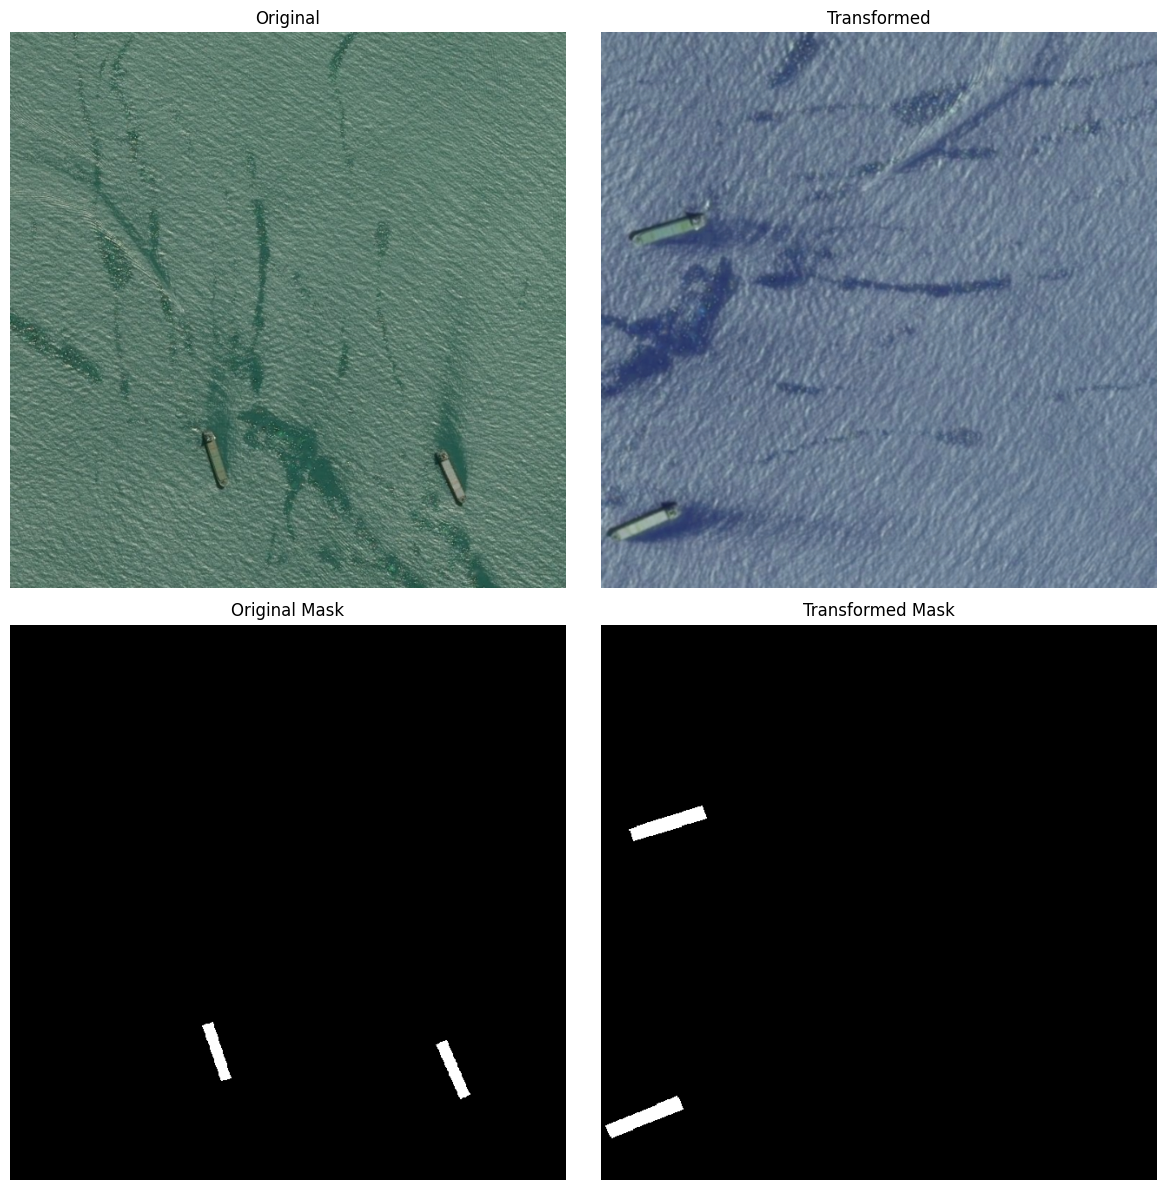

In [32]:
def visualize_ship_sample(dataset, idx):
    """
    Visualize a single ship dataset sample:
    Left: original image + mask
    Right: transformed image + mask
    """

    print(f"Processing image index {idx}...")
    img, mask = dataset[idx]

    # --- Load Transformed Image & Mask ---
    aug_val = transforms_val(image=img, mask=mask)
    val_img = aug_val['image']       # tensor C,H,W si ToTensorV2, numpy H,W,C si no
    val_mask = aug_val['mask']

    aug_train = transforms_train(image=img, mask=mask)
    tr_img = aug_train['image']
    tr_mask = aug_train['mask']

    # --- Plot ---
    fig, axes = plt.subplots(2, 2, figsize=(12,12))

    axes[0,0].imshow(unnormalize(val_img).permute(1,2,0))
    axes[0,0].axis('off')
    axes[0,0].set_title("Original")

    axes[0,1].imshow(unnormalize(tr_img).permute(1,2,0))
    axes[0,1].axis('off')
    axes[0,1].set_title("Transformed")

    axes[1,0].imshow(val_mask, cmap='gray', vmin=0, vmax=1)
    axes[1,0].axis('off')
    axes[1,0].set_title("Original Mask")

    axes[1,1].imshow(tr_mask, cmap='gray', vmin=0, vmax=1)
    axes[1,1].axis('off')
    axes[1,1].set_title("Transformed Mask")

    plt.tight_layout()
    plt.show()

# Plotting example
visualize_ship_sample(dataset_plot, idx=4401)

### Integrate augmentation pipeline into ShipDataset class

In [33]:
# Create datasets
train_dataset = ShipDataset(
    split='train',
    transform=transforms_train
)

valid_dataset = ShipDataset(
    split='valid',
    transform=transforms_val
)

test_dataset = ShipDataset(
    split='test',
    transform=transforms_val
)

print(f"Train: {len(train_dataset)}, Valid: {len(valid_dataset)}, Test: {len(test_dataset)}")

Train: 10230, Valid: 2558, Test: 15606


In [34]:
print(f"\n{'='*60}")
print("TESTING DATASET LOADING")
print('='*60)

try:
    # Try loading first sample from each dataset
    train_img, train_mask = train_dataset[0]
    valid_img, valid_mask = valid_dataset[0]
    test_img, test_mask = test_dataset[0]
    
    print(f"✓ Train sample loaded: image shape {train_img.shape}, mask shape {train_mask.shape}")
    print(f"✓ Valid sample loaded: image shape {valid_img.shape}, mask shape {valid_mask.shape}")
    print(f"✓ Test sample loaded: image shape {test_img.shape}, mask shape {test_mask.shape}")
    print("\n✓ ALL DATASETS WORKING CORRECTLY!")
except Exception as e:
    print(f"✗ Error loading samples: {e}")
    print("Please check your image directory and file paths")


TESTING DATASET LOADING
✗ Error loading samples: [Errno 2] No such file or directory: '/home/zawadzka/filtered_images/images/64416607b.jpg'
Please check your image directory and file paths


Hashed out the imports. Instead, merged model training directly into this notebook.

In [ ]:
# import pickle

# # Save datasets
# with open("datasets.pkl", "wb") as f:
#     pickle.dump({
#         "train_dataset": train_dataset,
#         "valid_dataset": valid_dataset,
#         "test_dataset": test_dataset
#     }, f)

In [ ]:
# # Step 2:
# import pickle

# with open("datasets.pkl", "rb") as f:
#     train_dataset, valid_dataset, test_dataset = pickle.load(f)


# # Step 3:
# from torch.utils.data import DataLoader

# # Just an example of how it could be done:
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8)
# val_loader   = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=8)
# test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)


## 2 Model Training

### 2.1 Model Architecture

Decided to make a model that returns a count of how many boats we have without a full reproduction of the boat masks.

In [ ]:
class BoatCountingCNN(nn.Module):
    """CNN for counting boats"""
    
    def __init__(self, dropout_rate=0.5):
        super(BoatCountingCNN, self).__init__()
        
        # Convolutional layers (same as before)
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        

        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 1)  # Single output for count
        )
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x  


Test to train one epoch.

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch - regression"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    pbar = tqdm(train_loader, desc='Training')
    for images, counts in pbar:
        images = images.to(device)
        counts = counts.float().unsqueeze(1).to(device)  # Shape: [batch, 1]
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)  # Raw predictions
        loss = criterion(outputs, counts)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        all_preds.extend(outputs.detach().cpu().numpy())
        all_labels.extend(counts.cpu().numpy())
        
        # Calculate MAE on the fly
        mae = np.mean(np.abs(np.array(all_preds) - np.array(all_labels)))
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'MAE': f'{mae:.2f}'
        })
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_mae = np.mean(np.abs(np.array(all_preds) - np.array(all_labels)))
    
    return epoch_loss, epoch_mae


In [ ]:
def validate(model, val_loader, criterion, device):
    """Validate the model - regression"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for images, counts in pbar:
            images = images.to(device)
            counts = counts.float().unsqueeze(1).to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, counts)
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(counts.cpu().numpy())
            
            mae = np.mean(np.abs(np.array(all_preds) - np.array(all_labels)))
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'MAE': f'{mae:.2f}'
            })
    
    epoch_loss = running_loss / len(val_loader.dataset)
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()
    
    # Calculate regression metrics
    mae = mean_absolute_error(all_labels, all_preds)
    mse = mean_squared_error(all_labels, all_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_labels, all_preds)
    
    return epoch_loss, mae, rmse, r2, all_preds, all_labels



Visualisation functions.

In [ ]:
def plot_training_history(history, save_path='training_history.png'):
    """Plot training history for regression"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot MAE
    axes[1].plot(history['train_mae'], label='Train MAE', marker='o')
    axes[1].plot(history['val_mae'], label='Val MAE', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Mean Absolute Error')
    axes[1].set_title('Training and Validation MAE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Training history plot saved to {save_path}")


def plot_prediction_scatter(y_true, y_pred, save_path='prediction_scatter.png'):
    """Scatter plot of predictions vs true counts"""
    plt.figure(figsize=(10, 8))
    
    # Scatter plot
    plt.scatter(y_true, y_pred, alpha=0.5, s=20)
    
    # Perfect prediction line
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    plt.xlabel('True Boat Count', fontsize=12)
    plt.ylabel('Predicted Boat Count', fontsize=12)
    plt.title('Predicted vs True Boat Counts', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add R² score
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    plt.text(0.05, 0.95, f'R² = {r2:.4f}\nMAE = {mae:.2f}', 
             transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Prediction scatter plot saved to {save_path}")


def plot_error_distribution(y_true, y_pred, save_path='error_distribution.png'):
    """Plot distribution of prediction errors"""
    errors = y_pred - y_true
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram of errors
    axes[0].hist(errors, bins=50, edgecolor='black', alpha=0.7)
    axes[0].axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
    axes[0].set_xlabel('Prediction Error (Predicted - True)', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Box plot by true count
    true_counts_unique = sorted(np.unique(y_true))
    error_by_count = [errors[y_true == count] for count in true_counts_unique]
    
    axes[1].boxplot(error_by_count, labels=[f'{int(c)}' for c in true_counts_unique])
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel('True Boat Count', fontsize=12)
    axes[1].set_ylabel('Prediction Error', fontsize=12)
    axes[1].set_title('Error Distribution by True Count', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Error distribution plot saved to {save_path}")


def visualize_count_predictions(model, dataset, device, num_samples=8):
    """Visualize model predictions on sample images"""
    model.eval()
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    mean = np.array([0.2118874, 0.3067525, 0.31743594])
    std = np.array([0.20147397, 0.1720894, 0.15324762])
    
    with torch.no_grad():
        for idx, ax in zip(indices, axes):
            image, true_count = dataset[idx]
            
            # Get prediction
            image_tensor = image.unsqueeze(0).to(device)
            output = model(image_tensor).item()
            pred_count = max(0, round(output))  # Round and clamp to non-negative
            
            # Denormalize image
            img_np = image.permute(1, 2, 0).cpu().numpy()
            img_np = img_np * std + mean
            img_np = np.clip(img_np, 0, 1)
            
            # Plot
            ax.imshow(img_np)
            ax.axis('off')
            
            # Color: green if within ±1, red otherwise
            error = abs(pred_count - true_count)
            color = 'green' if error <= 1 else 'red'
            title = f"True: {true_count} boats\nPred: {pred_count} boats\n(Raw: {output:.2f})"
            ax.set_title(title, fontsize=10, color=color, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('sample_count_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Sample predictions saved to sample_count_predictions.png")


### 2.2 Training loops

Will have to export to .py file to run the file on GPU.

In [ ]:
print("\n" + "="*80)
print("BOAT COUNTING CNN - TRAINING PIPELINE (REGRESSION)")
print("="*80)

BATCH_SIZE = 16
NUM_WORKERS = 4
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
SAVE_DIR = 'checkpoints'

os.makedirs(SAVE_DIR, exist_ok=True)

print(f"\nConfiguration:")
print(f"  Task: Boat Counting (Regression)")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Workers: {NUM_WORKERS}")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)

# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Using device: {device}")

model = BoatCountingCNN(dropout_rate=0.5).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✓ Total parameters: {total_params:,}")
print(f"✓ Trainable parameters: {trainable_params:,}")

# Loss and Optimizer (MSE for regression)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# Training History
history = {
    'train_loss': [],
    'train_mae': [],
    'val_loss': [],
    'val_mae': [],
    'val_rmse': [],
    'val_r2': []
}

best_val_mae = float('inf')

Training.

In [ ]:
print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 80)
    
    # Train
    train_loss, train_mae = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_mae, val_rmse, val_r2, val_preds, val_labels = validate(
        model, val_loader, criterion, device
    )
    
    # Update learning rate
    scheduler.step(val_mae)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_mae'].append(train_mae)
    history['val_loss'].append(val_loss)
    history['val_mae'].append(val_mae)
    history['val_rmse'].append(val_rmse)
    history['val_r2'].append(val_r2)
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train MAE: {train_mae:.2f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val MAE:   {val_mae:.2f}")
    print(f"  Val RMSE:   {val_rmse:.2f} | Val R²:    {val_r2:.4f}")
    
    # Save best model
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_mae': val_mae,
            'val_rmse': val_rmse,
            'val_r2': val_r2,
        }, os.path.join(SAVE_DIR, 'best_model_mae.pth'))
        print(f"  ✓ Saved best model (MAE: {val_mae:.2f})")

print("\n" + "="*80)
print("TRAINING COMPLETED!")
print("="*80)
print(f"Best validation MAE: {best_val_mae:.2f}")

In [ ]:
# Evaluation and Visualization
# ============================================================================
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

plot_training_history(history)

# Load best model
checkpoint = torch.load(os.path.join(SAVE_DIR, 'best_model_mae.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\n✓ Loaded best model from epoch {checkpoint['epoch']+1}")

# Test on validation set
print("\n" + "="*80)
print("FINAL EVALUATION ON VALIDATION SET")
print("="*80)

_, test_mae, test_rmse, test_r2, test_preds, test_labels = validate(
    model, val_loader, criterion, device
)

print(f"\nTest Set Metrics:")
print(f"  MAE (Mean Absolute Error): {test_mae:.2f} boats")
print(f"  RMSE (Root Mean Squared Error): {test_rmse:.2f} boats")
print(f"  R² Score: {test_r2:.4f}")
print(f"  Mean True Count: {test_labels.mean():.2f} boats")
print(f"  Mean Predicted Count: {test_preds.mean():.2f} boats")

# Generate visualizations
plot_prediction_scatter(test_labels, test_preds)
plot_error_distribution(test_labels, test_preds)
visualize_count_predictions(model, valid_dataset, device, num_samples=8)

# Save results
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

with open('training_history_count.json', 'w') as f:
    json.dump(history, f, indent=4)

results = {
    'test_mae': float(test_mae),
    'test_rmse': float(test_rmse),
    'test_r2': float(test_r2),
    'mean_true_count': float(test_labels.mean()),
    'mean_pred_count': float(test_preds.mean()),
    'best_val_mae': float(checkpoint['val_mae']),
}

with open('test_results_count.json', 'w') as f:
    json.dump(results, f, indent=4)

print("✓ All results saved!")
print("\nGenerated files:")
print("  - training_history_count.json")
print("  - test_results_count.json")
print("  - checkpoints/best_model_mae.pth")
print("  - training_history.png")
print("  - prediction_scatter.png")
print("  - error_distribution.png")
print("  - sample_count_predictions.png")